In [1]:
# import packages
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns 
import numpy as np
from matplotlib_venn import venn2

## Read BGI input

In [2]:
#colors
sns.set_style("whitegrid")
bgi_main = '#5eaab3'
bgi_lght = '#aacfd5'
ill_main = '#ee7339'
shared_cl = '#94a577'
main_cl = '#1c4e9c'

In [3]:
# read in the fastQC results
bgi = pd.read_csv('input/BGI_fastqc_1990.csv', sep=',')
bgi['Filename'] = bgi['Filename'].str.replace('_2.fq.gz', '')

bgi.tail()

/var/folders/5j/pvj6k02n3mn9ztpn77vjtfzw0000gn/T/ipykernel_20790/3251991594.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  bgi['Filename'] = bgi['Filename'].str.replace('_2.fq.gz', '')


,Filename,Platform,Total Sequences,Sequences flagged as poor quality,Sequence length,%GC,Per base sequence quality,Sequence Duplication Levels,Total Deduplicated Percentage,Overrepresented sequences,Adapter Content,sample_name
1985,VA6KWA,BGI,14263705,0,150,46,pass,pass,94.0,pass,pass,VA6KWA
1986,VM11NF,BGI,13404053,0,150,46,pass,pass,85.0,pass,pass,VM11NF
1987,VXSG83,BGI,15291805,0,150,45,pass,pass,94.0,pass,pass,VXSG83
1988,VQ9DGJ,BGI,16072275,0,150,46,pass,pass,93.0,pass,pass,VQ9DGJ
1989,V4NQIN,BGI,15929089,0,150,48,pass,pass,95.0,pass,pass,V4NQIN


## Read Illumina input

In [4]:
ill = pd.read_csv('input/Illumina_fastqc_1990.csv', sep=',')
ill['Filename'] = ill['Filename'].str.replace('_2.fq.gz', '')
ill.tail()

/var/folders/5j/pvj6k02n3mn9ztpn77vjtfzw0000gn/T/ipykernel_20790/3753808632.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  ill['Filename'] = ill['Filename'].str.replace('_2.fq.gz', '')


,Filename,Platform,Total Sequences,Sequences flagged as poor quality,Sequence length,%GC,Per base sequence quality,Sequence Duplication Levels,Total Deduplicated Percentage,Overrepresented sequences,Adapter Content,sample_name
1985,VE0WMY,Illumina,14759347,0,150,45,pass,pass,80.0,pass,pass,VE0WMY
1986,VGCQOM,Illumina,17140513,0,150,42,pass,warn,65.0,pass,pass,VGCQOM
1987,VWZEWE,Illumina,13462755,0,150,44,pass,warn,66.0,pass,pass,VWZEWE
1988,V5IRLB,Illumina,15160644,0,150,48,pass,pass,81.0,pass,pass,V5IRLB
1989,V0BVU1,Illumina,17351316,0,150,44,pass,pass,81.0,pass,pass,V0BVU1


In [5]:
mrg = pd.merge(bgi, ill, on='Filename', how='inner', suffixes=('_bgi', '_ill'))
mrg.to_excel('results/Combined_fastQC_results.xlsx', index=False)
mrg.head()

# exclude bad smpls
badsmpls = pd.read_excel('input/bad_samples_All-261.xlsx')
# remove the bad samples from the merged dataframe
mrg = mrg[~mrg['Filename'].isin(badsmpls['Filename'])]
len(mrg)

1729

## RAD

In [6]:
print('Total number of overlaping samples: ' + str(len(mrg)))

Total number of overlaping samples: 1729


### Main parameters to compare:
- Total Sequences
- Sequences flagged as poor quality
- Sequence length_bgi
- %GC
- Per base sequence quality
- Sequence Duplication Levels
- Total Deduplicated Percentage
- Overrepresented sequences
- Adapter Content

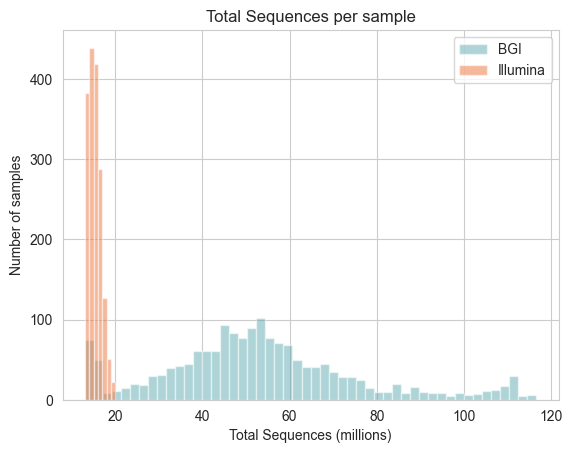

In [28]:
# Total Sequences

plt.hist(mrg['Total Sequences_bgi']/1000000, bins=50, alpha=0.5, label='BGI', color=bgi_main)
plt.hist(mrg['Total Sequences_ill']/1000000, bins=7, alpha=0.5, label='Illumina', color=ill_main)
plt.legend(loc='upper right')
plt.xlabel('Total Sequences (millions)')
plt.ylabel('Number of samples')
plt.title('Total Sequences per sample')
plt.savefig('results/Total_Sequences.png', dpi=300)

In [11]:
# Sequences flagged as poor quality

print('\033[1m BGI. Sequences flagged as poor quality \033[0m')
print(mrg['Sequences flagged as poor quality_bgi'].value_counts(), '\n')

print('\033[1m Illumina. Sequences flagged as poor quality \033[0m')
print(mrg['Sequences flagged as poor quality_ill'].value_counts(), '\n')

 BGI. Sequences flagged as poor quality 
0    1729
Name: Sequences flagged as poor quality_bgi, dtype: int64 

 Illumina. Sequences flagged as poor quality 
0    1729
Name: Sequences flagged as poor quality_ill, dtype: int64 



In [12]:
#Sequence length

print('\033[1m BGI. Sequence length \033[0m')
print(mrg['Sequence length_bgi'].value_counts(), '\n')

print('\033[1m Illumina. Sequence length \033[0m')
print(mrg['Sequence length_ill'].value_counts(), '\n')

 BGI. Sequence length 
150    1729
Name: Sequence length_bgi, dtype: int64 

 Illumina. Sequence length 
150    1729
Name: Sequence length_ill, dtype: int64 



In [7]:
# Calculate deltas (differences between paired samples)
mrg['cg_delta'] = mrg['%GC_ill'] - mrg['%GC_bgi']

# Test normality
from scipy.stats import shapiro
shapiro(mrg['cg_delta'])

from scipy.stats import wilcoxon
stat, p = wilcoxon(mrg['%GC_ill'], mrg['%GC_bgi'])
#print("Wilcoxon test statistic:", stat)
if p<0.05:
    print("Nope, it's significantly not normal, p-value:", p)
    # OR Wilcoxon test
    from scipy.stats import wilcoxon
    stat, p_val = wilcoxon(mrg['%GC_ill'], mrg['%GC_bgi'])
    print("Paired wilcoxon p-value:", p_val)
else:
    print("It is normal, p-value:", p)
    # Paired t-test
    from scipy.stats import ttest_rel
    t_stat, p_val = ttest_rel(mrg['%GC_ill'], mrg['%GC_bgi'])
    print("Paired t-test p-value:", p_val)

#Quantify Effect Size
#Stat significance ≠ practical significance (Calculate Cohen’s d for paired samples. Interpret: ~0.2 = small; ~0.5 = medium; ~0.8 = large)
cohen_d = mrg['cg_delta'].mean() / mrg['cg_delta'].std()
print("Cohen's d ≈ ", cohen_d.round(2))

Nope, it's significantly not normal, p-value: 4.255488342638626e-25
Paired wilcoxon p-value: 4.255488342638626e-25
Cohen's d ≈  0.24


45.27 1.82
45.61 1.61


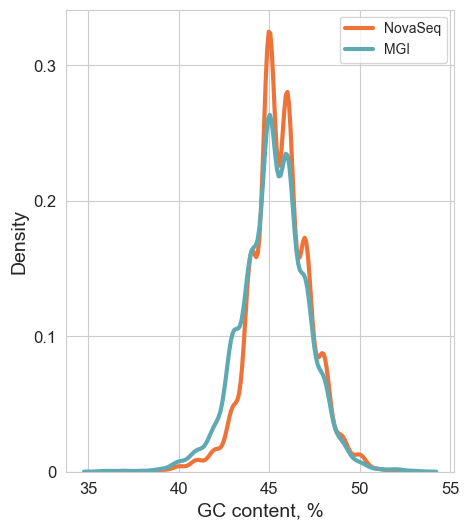

In [24]:
from scipy.stats import wilcoxon
from scipy.stats import pearsonr

plt.figure(figsize=(5, 6))
sns.kdeplot(mrg['%GC_ill'], label='NovaSeq', color=ill_main, linewidth=3)
sns.kdeplot(mrg['%GC_bgi'], label='MGI', color=bgi_main, linewidth=3)
plt.xlabel("GC content, %", fontsize=14)
plt.ylabel('Density', fontsize=14)
# custom ticks
plt.xticks([35, 40, 45, 50, 55], labels=['35', '40', '45', '50', '55'], fontsize=12)
plt.yticks([0, 0.1,0.2,0.3],labels= [0, 0.1,0.2,0.3], fontsize=12)
plt.grid()
plt.legend()

print(mrg['%GC_bgi'].mean().round(2), mrg['%GC_bgi'].std().round(2))
print(mrg['%GC_ill'].mean().round(2), mrg['%GC_ill'].std().round(2))
plt.grid()

plt.savefig('results/Figure_3/Fig3a_GC_content.png', dpi=300, bbox_inches='tight')
plt.savefig('results/Figure_3/Fig3a_GC_content.svg', bbox_inches='tight')

plt.show()

In [15]:
# Per base sequence quality

print('\033[1m BGI. Per base sequence quality \033[0m')
print(mrg['Per base sequence quality_bgi'].value_counts(), '\n')

print('\033[1m Illumina. Per base sequence quality \033[0m')
print(mrg['Per base sequence quality_ill'].value_counts(), '\n')

 BGI. Per base sequence quality 
pass    1729
Name: Per base sequence quality_bgi, dtype: int64 

 Illumina. Per base sequence quality 
pass    1729
Name: Per base sequence quality_ill, dtype: int64 



In [ ]:
# Sequence Duplication Levels

print('\033[1m BGI. Sequence Duplication Levels \033[0m')
print(mrg['Sequence Duplication Levels_bgi'].value_counts(), '\n')

print('\033[1m Illumina. Sequence Duplication Levels \033[0m')
print(mrg['Sequence Duplication Levels_ill'].value_counts(), '\n')

#sns.jointplot(data=mrg, x="Sequence Duplication Levels_bgi", y="Sequence Duplication Levels_ill", s=9,palette='Set1')
#plt.savefig('results/Sequence_Duplication_Levels.png', dpi=300)


 BGI. Sequence Duplication Levels 
pass    1412
warn     295
fail      22
Name: Sequence Duplication Levels_bgi, dtype: int64 

 Illumina. Sequence Duplication Levels 
pass    1560
warn     168
fail       1
Name: Sequence Duplication Levels_ill, dtype: int64 



<Figure size 640x480 with 0 Axes>

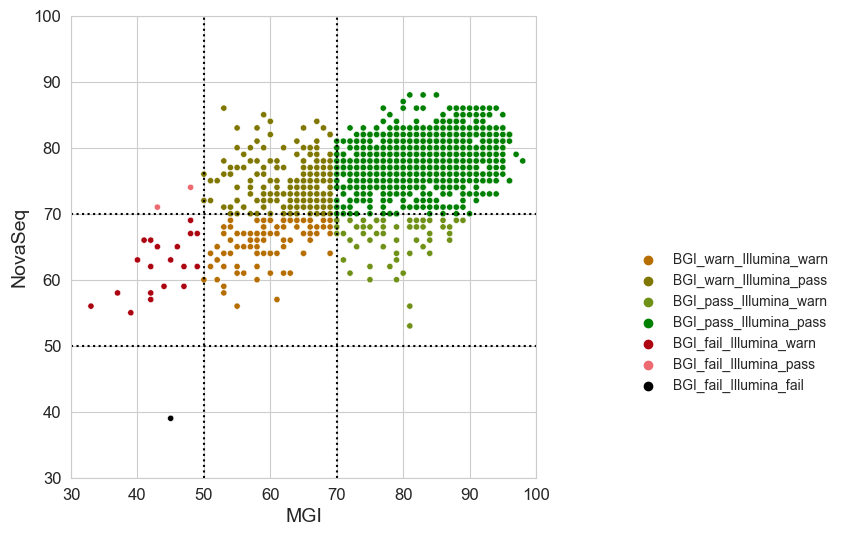

In [21]:
# Total Deduplicated Percentage
plt.figure(figsize=(6, 6))
seq_dupl_labels = []
for a in range(len(list(mrg['Sequence Duplication Levels_bgi']))):
    seq_dupl_labels.append("BGI_" + list(mrg['Sequence Duplication Levels_bgi'])[a] + "_Illumina_" + list(mrg['Sequence Duplication Levels_ill'])[a])
mrg['Sequence Duplication Levels'] = seq_dupl_labels
mrg = mrg.sort_values(by='Sequence Duplication Levels', ascending=False)


sns.scatterplot(data=mrg, x="Total Deduplicated Percentage_bgi", y="Total Deduplicated Percentage_ill",hue='Sequence Duplication Levels', s=20, palette={
    'BGI_pass_Illumina_pass': 'green',
    'BGI_warn_Illumina_pass': '#807700',
    'BGI_pass_Illumina_warn': '#6f9117',
    'BGI_warn_Illumina_warn': '#b66e00',
    'BGI_warn_Illumina_fail': '#72030a',
    'BGI_fail_Illumina_warn': '#ac0511',
    'BGI_fail_Illumina_fail': 'black',
    'BGI_fail_Illumina_pass': '#ed6a70'
})
# add lines at 50% and 75%
plt.axhline(50, color='black', linestyle=':')
plt.axvline(50, color='black', linestyle=':')
plt.axhline(70, color='black', linestyle=':')
plt.axvline(70, color='black', linestyle=':')

#plt.title('Total Deduplicated Percentage', y=1.2, fontsize = 16)
plt.xlim(30,100)
plt.ylim(30,100)
plt.xlabel('MGI', fontsize=14)
plt.ylabel('NovaSeq', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# legend without border

legend = plt.legend(bbox_to_anchor=(1.2, 0.5), loc='upper left', borderaxespad=0)
legend.get_frame().set_linewidth(0.0)

plt.savefig('results/Figure_3/Fig3b.png', dpi=300, bbox_inches='tight')
plt.savefig('results/Figure_3/Fig3b.svg', bbox_inches='tight')

In [18]:
sub = mrg.loc[mrg['Sequence Duplication Levels_ill'] != "pass"]
print(sub.shape)
print(mrg.loc[mrg['Sequence Duplication Levels_bgi'] != "pass"].shape)

(169, 24)
(317, 24)


In [19]:
# Overrepresented sequences
print('\033[1m BGI. Overrepresented sequences \033[0m')
print(mrg['Overrepresented sequences_bgi'].value_counts(), '\n')

print('\033[1m Illumina. Overrepresented sequences \033[0m')
print(mrg['Overrepresented sequences_ill'].value_counts(), '\n')

 BGI. Overrepresented sequences 
pass    1728
warn       1
Name: Overrepresented sequences_bgi, dtype: int64 

 Illumina. Overrepresented sequences 
pass    1728
warn       1
Name: Overrepresented sequences_ill, dtype: int64 



In [20]:
print('\033[1m BGI. Overrepresented sequences \033[0m')
mrg[mrg['Overrepresented sequences_bgi'] == 'warn']

 BGI. Overrepresented sequences 


,Filename,Platform_bgi,Total Sequences_bgi,Sequences flagged as poor quality_bgi,Sequence length_bgi,%GC_bgi,Per base sequence quality_bgi,Sequence Duplication Levels_bgi,Total Deduplicated Percentage_bgi,Overrepresented sequences_bgi,...,Sequences flagged as poor quality_ill,Sequence length_ill,%GC_ill,Per base sequence quality_ill,Sequence Duplication Levels_ill,Total Deduplicated Percentage_ill,Overrepresented sequences_ill,Adapter Content_ill,sample_name_ill,Sequence Duplication Levels
288,VSTACS,BGI,50964927,0,150,48,pass,pass,85.0,warn,...,0,150,49,pass,pass,83.0,pass,pass,VSTACS,BGI_pass_Illumina_pass


In [21]:
print('\033[1m Illumina. Overrepresented sequences \033[0m')
mrg[mrg['Overrepresented sequences_ill'] == 'warn']

 Illumina. Overrepresented sequences 


,Filename,Platform_bgi,Total Sequences_bgi,Sequences flagged as poor quality_bgi,Sequence length_bgi,%GC_bgi,Per base sequence quality_bgi,Sequence Duplication Levels_bgi,Total Deduplicated Percentage_bgi,Overrepresented sequences_bgi,...,Sequences flagged as poor quality_ill,Sequence length_ill,%GC_ill,Per base sequence quality_ill,Sequence Duplication Levels_ill,Total Deduplicated Percentage_ill,Overrepresented sequences_ill,Adapter Content_ill,sample_name_ill,Sequence Duplication Levels
1141,V2EKJ0,BGI,61169728,0,150,47,pass,pass,83.0,pass,...,0,150,42,pass,warn,65.0,warn,pass,V2EKJ0,BGI_pass_Illumina_warn


In [22]:
# Adapter Content
print('\033[1m BGI. Adapter Content \033[0m')
print(mrg['Adapter Content_bgi'].value_counts(), '\n')

print('\033[1m Illumina. Adapter Content \033[0m')
print(mrg['Adapter Content_ill'].value_counts(), '\n')

 BGI. Adapter Content 
pass    1729
Name: Adapter Content_bgi, dtype: int64 

 Illumina. Adapter Content 
pass    1729
Name: Adapter Content_ill, dtype: int64 



In [23]:
# check if samples with failed overrepresented sequences also had exceeded duplication levels

sub = list(mrg.loc[mrg['Sequence Duplication Levels_ill'] != "pass"]['Filename'])
print("V2EKJ0" in sub)

sub = list(mrg.loc[mrg['Sequence Duplication Levels_bgi'] != "pass"]['Filename'])
print("VSTACS" in sub)



True
False


In [24]:
# samples to remove

to_remove = list(mrg.loc[mrg['Sequence Duplication Levels_ill'] != "pass"]['Filename']) + list(mrg.loc[mrg['Sequence Duplication Levels_bgi'] != "pass"]['Filename']) + ["V2EKJ0","VSTACS"]
print(len(to_remove))

to_remove = list(set(to_remove))
print(len(to_remove))

# Open a file in write mode
with open('samples_qc_failed_to_remove.txt', 'a+') as file:
    # Iterate through the list and write each element to the file
    for item in to_remove:
        file.write(f'{item}\n')  # Write each element followed by a newline

488
378


## THE END